In [1]:
#import relevant libraries
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout, Reshape, Conv2DTranspose, Embedding
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.losses import MeanSquaredError
import numpy as np
import matplotlib.pyplot as plt
import os

2022-09-16 22:24:40.082135: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


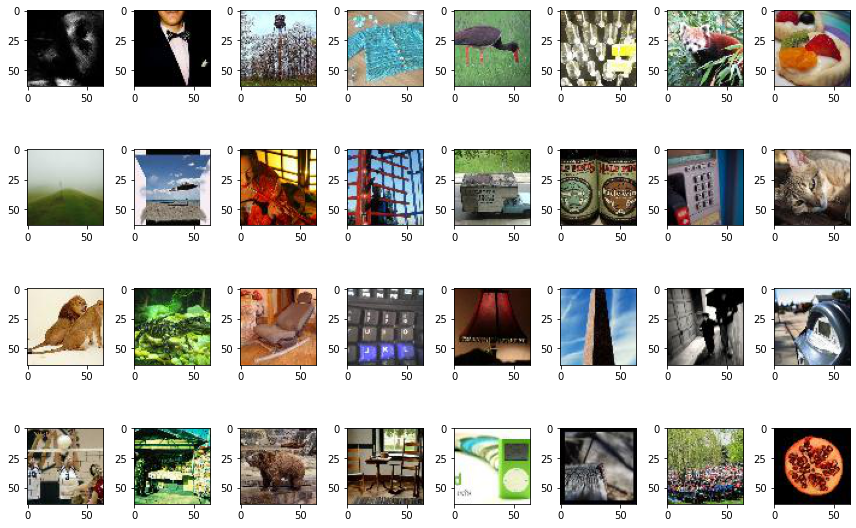

Image dimension in the dataset:  (64, 64, 3)


In [2]:
#Display some test images from the test set of tiny-imagenet
def display_formatted_image(d_choice, num_row, num_col):
    #see few examples
    # plot images
    d_size = 0
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(num_row*num_col):
        ax = axes[int(i/num_col), i%num_col]
        img = img_to_array(load_img("./Data/tiny-imagenet-200/test/images/test_"+str(d_choice[i])+".JPEG"))
        img = img.astype(int)
        
        d_size = img.shape
        ax.imshow(img, cmap='gray')
        #ax.set_title('Label: {}'.format(labels[i]))
    plt.tight_layout()
    plt.show()
    print("Image dimension in the dataset: ",d_size)
    
display_formatted_image(np.random.choice(10000, size=32, replace=False), 4, 8)

In [2]:
#VQ-VAE architechture
class VQ_VAE_tinyImagenet(object):
    def __init__(self, dict_size):
        #self.model = None
        #hyperparameters haven't been tuned: using within some prescribed heuristic level
        self.arch_hyperparameters = {'l2_conv': 0.001, 
                                     'l2_emb': 0.001,
                                     'dropout': 0.2,
                                     'lr': 0.001,
                                     'batch_size': 128
                                     }
        
        #data dimension will be automatically taken care by keras
        self.data_dims = (64, 64, 3)
        self.encode_dims = (26, 26, 64)
        
        #the idea is getting 16^25 different latents for the decoder (16 is selected as the as the number of code-vectors because root(200) ~ 16, the dataset has 200 labels)
        self.code_book_dims = (dict_size, 64)
        
        self.optimizer = None
        self.code_book = None
        self.Encoder = None
        self.Decoder = None
        self.commit_beta = 1    #paper said anything between 0.1-2 has similar effects
        
        
    
    def save_model(self, path):
        self.Encoder.save(path+"Encoder")
        self.Decoder.save(path+"Decoder")
        self.code_book.save(path+"code_book")
    
    def load_mymodel(self, path):
        print("Loading Model")
        self.Encoder = load_model(path+"Encoder")
        self.Encoder.compile()
        self.Encoder.summary()
        
        self.code_book = load_model(path+"code_book")
        self.code_book.compile()
        self.code_book.summary()
        
        self.Decoder = load_model(path+"Decoder")
        self.Decoder.compile()
        self.Decoder.summary()
        
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.arch_hyperparameters['lr'])
        
    def encoder(self, inp):
        #Encoder 
        #Note first 2 elements are number of maps in the op and the kernel size of the layer
        #Layer e1
        enc_op = Conv2D(16, (5,5), strides=(2,2), activation='elu', padding='valid', kernel_regularizer=l2(self.arch_hyperparameters['l2_conv']), name = 'enc_CONV_L1')(inp)      #l1_conv 
        #enc_op = MaxPool2D((5, 5), strides=(2,2), padding='valid', name = 'enc_MaxPool_L1')(enc_op)   #l1_maxpool
        #layer e2
        enc_op = Conv2D(32, (3,3), strides=(1,1), activation='elu', padding='valid', kernel_regularizer=l2(self.arch_hyperparameters['l2_conv']), name = 'enc_CONV_L2')(enc_op)   #l2_conv
        #enc_op = MaxPool2D((3, 3), strides=(1,1), padding='valid', name = 'enc_MaxPool_L2')(enc_op)   #l2 maxpool
        #layer e3
        enc_op = Conv2D(64, (3,3), strides=(1,1), activation='elu', padding='valid', kernel_regularizer=l2(self.arch_hyperparameters['l2_conv']), name = 'enc_CONV_L3')(enc_op)   #l3_conv
        
        
        return enc_op
    #this is used to see if the quantizer is giving the output correctly, need not use it
    def quantizer_sanity_check(self, enc_op, quant_val):
        is_correct = True
        emb_val = self.code_book.get_layer("Embedding_latent").get_weights()[0]
        print(emb_val.shape)
        #over examples
        for ex in range(enc_op.shape[0]):
            #over i in (i, j) of feature maps
            for i in range(enc_op.shape[1]):
                for j in range(enc_op.shape[2]):
                    emb_ij = enc_op[ex, i, j]
                    indx_min = -1
                    dist = np.inf
                    #check over all the emb_val
                    for l in range(emb_val.shape[0]):
                        len_ijl = np.linalg.norm(emb_val[l]-emb_ij, 2)
                        
                        if len_ijl < dist:
                            indx_min = l
                            dist = len_ijl
                        
                    if not np.allclose(quant_val[ex, i, j], emb_val[indx_min]):
                        is_correct=False
                        
        return is_correct
    
    def quantizer(self, enc_op):
        #note 16 here is a dict size, which (experimented with 3 values)
        enc_op_temp = np.expand_dims(enc_op.numpy(), axis=3)  #covert to (b,5,5,1,64)
        emb_vector  =  np.expand_dims(self.code_book.get_layer("Embedding_latent").get_weights()[0], axis= (0,1,2))  #(1,1,1,16,64)
        #this will give (b,5,5,16,64): for every example, i,j we get a (16, 64) dimensional vector, calculate dist -> left with 16 numbers-> choose maximum
        
        dist_ij = enc_op_temp - emb_vector
        #calculate the distance for every i,j and every subject
        q_index = np.argmin(np.sum(dist_ij*dist_ij, axis=4), axis=3)
        #access these embedding vectors
        quant_enc_op = self.code_book(q_index)
        return quant_enc_op
    
    
    
    def decoder(self, latent_enc):
        #upsampling fc
        #dec_op = Dense(1600, activation='elu', name='dec_fc')(latent_enc)   #increase dimension of latent
        #dec_op = Dropout(self.arch_hyperparameters['dropout'], name = 'dec_Dropout')(dec_op)
        #inverse flatten
        #dec_op = Reshape((5, 5, 64), name='dec_inv_Flatten')(dec_op)  #reshape
        
        #inverse l3
        dec_op = Conv2DTranspose(32, (3,3), strides=(1,1), activation='elu', padding='valid', kernel_regularizer=l2(self.arch_hyperparameters['l2_conv']), name = 'dec_inv_CONV_L3')(latent_enc)   #l3_convTranspose
        #inverse l2
        dec_op = Conv2DTranspose(16, (4,4), strides=(1,1), activation='elu', padding='valid', kernel_regularizer=l2(self.arch_hyperparameters['l2_conv']), name = 'dec_inv_CONV_L2')(dec_op)   #l2_convTranspose
        #inverse l1
        dec_op = Conv2DTranspose(3, (4,4), strides=(2,2), activation='sigmoid', padding='valid', kernel_regularizer=l2(self.arch_hyperparameters['l2_conv']), name = 'dec_inv_CONV_L1')(dec_op)      #l1_convTranspose
        
        return dec_op
        
    def makeModel(self):
        #make the encoder
        inp = Input(shape=self.data_dims, name='enc_Input')
        self.Encoder = Model(inputs=inp, outputs=self.encoder(inp), name='Encoder')
        self.Encoder.compile()
        self.Encoder.summary()
        #make the decoder
        dec_latent_inp = Input(shape = self.encode_dims, name='dec_latent_Input')
        self.Decoder = Model(inputs=dec_latent_inp, outputs=self.decoder(dec_latent_inp), name='Decoder')
        self.Decoder.compile()
        #make the code-book
        quant_inp = Input(shape=[],name='quant_inp')
        self.code_book = Model(inputs= quant_inp, outputs=Embedding(self.code_book_dims[0], self.code_book_dims[1], embeddings_regularizer=l2(self.arch_hyperparameters['l2_emb']), name='Embedding_latent')(quant_inp), name='code_book')
        self.code_book.compile()
        self.code_book.summary()
        #self.model = Model(inputs=inp, outputs=self.Decoder(self.Encoder(inp)), name='VQ_VAE_Mainak')
        #print(self.code_book.get_layer('Embedding_latent').name, self.code_book.get_layer('Embedding_latent').get_weights()[0])
        self.Decoder.summary()
        
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.arch_hyperparameters['lr'])
        
    
    def forward_prop(self, input_batch):
        #encoder output
        enc_op = self.Encoder(input_batch)
        #print(enc_op.shape)
        #quantize output
        quant_enc_op = self.quantizer(enc_op)
        #print(quant_enc_op.shape)
        
        #this was written to check if the quantization was correct
        #print("Quantization is ok: ",self.quantizer_sanity_check(enc_op.numpy(), quant_enc_op.numpy()))

        #decoder output
        dec_op = self.Decoder(quant_enc_op)
        #print(dec_op.shape)
        return enc_op, quant_enc_op, dec_op
    
    
    def losses(self, inp, dec_op, enc_op, quant_enc_op):
        #log P(x|z_e(x)), given encoder the decoder is thought to output the x, gaussian assumption -> mse
        recons_loss = MeanSquaredError()(inp, dec_op)
        #this is the vq_loss, we need to stop the gradients at encoder output z_e(x), to learn the tables
        vq_loss = MeanSquaredError()(tf.stop_gradient(enc_op), quant_enc_op)
        #this is the commitment loss, used to make the encoder commit to the q_values and stay near them
        commit_loss = MeanSquaredError()(enc_op, tf.stop_gradient(quant_enc_op))
        
        return recons_loss, vq_loss, self.commit_beta*commit_loss
    
    #def back_prop(self, inp, dec_op, enc_op, quant_enc_op):
    def back_prop(self, inp):
        
        with tf.GradientTape(persistent=True) as tape:
            #enc_op, quant_enc_op, dec_op = self.forward_prop(inp)
            enc_op = self.Encoder(inp)
            
            quant_enc_op = self.quantizer(enc_op)
            vq_loss = MeanSquaredError()(tf.stop_gradient(enc_op), quant_enc_op)
            commit_loss = self.commit_beta*MeanSquaredError()(enc_op, tf.stop_gradient(quant_enc_op))
            
            quant_enc_op = enc_op + tf.stop_gradient(quant_enc_op - enc_op)
            
            dec_op = self.Decoder(quant_enc_op)
            recons_loss = MeanSquaredError()(inp, dec_op)
            
    
        #backprop    
        #decoder loss depends only on reconstruction loss
        grad_Decoder = tape.gradient(recons_loss, self.Decoder.trainable_variables)
        self.optimizer.apply_gradients(zip(grad_Decoder, self.Decoder.trainable_variables))
        #print(self.Decoder.trainable_variables)
        #embeddings are learnt using vq_loss
        grad_Embedding = tape.gradient(vq_loss, self.code_book.trainable_variables)
        
        self.optimizer.apply_gradients(zip(grad_Embedding, self.code_book.trainable_variables))
        #Encoder has 2 part: 1) from the commitment losss
        grad_Encoding_com_grad = tape.gradient(commit_loss, self.Encoder.trainable_variables)
        self.optimizer.apply_gradients(zip(grad_Encoding_com_grad, self.Encoder.trainable_variables))
        #part 2:) reconstruction loss: gradients are copied
        grad_Encoding_recon_loss = tape.gradient(recons_loss, self.Encoder.trainable_variables)
        self.optimizer.apply_gradients(zip(grad_Encoding_recon_loss, self.Encoder.trainable_variables))
        
    def train_Model(self, data, n_epochs):
        #self.Encoder.compile(optimizer=tf.keras.Optimizer.Adam(learning_rate=self.arch_hyperparameters['lr']))
        #self.code_book.compile(optimizer=tf.keras.Optimizer.Adam(learning_rate=self.arch_hyperparameters['lr']))
        #self.Decoder.compile(optimizer=tf.keras.Optimizer.Adam(learning_rate=self.arch_hyperparameters['lr']))
        ep_length = int(np.ceil(data.shape[0]/self.arch_hyperparameters['batch_size']))
        loss_history = {'recon_loss': [],
                    'vq_loss': [],
                    'comm_loss': []}
        for i in range(n_epochs):
            d_loss = data[np.random.choice(100000, 5000, replace=False)]
            enc_op, quant_enc_op, dec_op = self.forward_prop(d_loss)
            r, v, c = self.losses(d_loss, dec_op, enc_op, quant_enc_op)
            
            loss_history['recon_loss'].append(r)
            loss_history['vq_loss'].append(v)
            loss_history['comm_loss'].append(c)
            tot_loss = r+v+c
            if i%2 == 0:
                print("Loss at epoch {}: {}".format(i, tot_loss))
            
            np.random.shuffle(data)
            for j in range(ep_length):
                batch = None
                if j == ep_length -1:
                    batch = data[j*self.arch_hyperparameters['batch_size']:data.shape[0]]
                else:
                    batch = data[j*(self.arch_hyperparameters['batch_size']):(j+1)*(self.arch_hyperparameters['batch_size'])]
                enc_op, quant_enc_op, dec_op = self.forward_prop(batch)
                #train with the batch
                #self.back_prop(batch, dec_op, enc_op, quant_enc_op)
                self.back_prop(batch)
                
        return loss_history        

In [ ]:
train = np.load("./Data/tiny-imagenet-200/train.npy")

In [ ]:
my_model = VQ_VAE_tinyImagenet(16)
loss_array = my_model.train_Model(train, 10)

In [3]:
def plot_comp_curves(losses, model_det):
    plt.plot(losses['recon_loss'], label='recon loss')
    plt.plot(losses['vq_loss'], label='vq loss')
    #plt.plot(losses['recon_loss'] + losses['comm_loss'], label='total loss')
    plt.legend()
    plt.xlabel('Epoch', size=15)
    plt.ylabel('Loss', size=15)
    plt.title('Learning Curve with code book length= '+str(model_det), size=15)
    plt.show()
#print(loss_array['recon_loss'][-1]+loss_array['vq_loss'][-1])

#plot_comp_curves(loss_array, 16)

In [ ]:
my_model = VQ_VAE_tinyImagenet(16)
my_model.load_mymodel("./VQ_VAE_16/model/")

In [ ]:
my_model.train_Model(train, 1)

In [ ]:
my_model.save_model("./VQ_VAE_16/model/")

In [ ]:
#Display some test images from the test set of tiny-imagenet
def display_formatted_image_grid(d_choice, num_row, num_col):
    #see few examples
    # plot images
    d_size = 0
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(num_row*num_col):
        ax = axes[int(i/num_col), i%num_col]
        img = d_choice[i]
        ax.imshow(img, cmap='gray')
        #ax.set_title('Label: {}'.format(labels[i]))
    plt.tight_layout()
    plt.show()
    
def display_10_10(dataset, my_model):
    inp_img = dataset[np.random.choice(dataset.shape[0], 100, replace=False)]
    display_formatted_image_grid(inp_img, 10, 10)
    _, _, recon_op = my_model.forward_prop(inp_img)
    display_formatted_image_grid(recon_op, 10, 10)

display_10_10(test, my_model)

In [3]:
cv_set = train = np.load("./Data/tiny-imagenet-200/cv.npy")
#display_10_10(cv_set, my_model)

In [4]:
def save_grid(data, savePath):
    from PIL import Image
    #tiny image is 64x64 
    grid_10_10 = Image.new('RGB', (640,640))
    idx = 0
    for i in range(0, 640, 64):
        for j in range(0, 640, 64):
            
            im = (data[idx]*255).astype('uint8')
            im = Image.fromarray(im)
            grid_10_10.paste(im, (i,j))
            idx += 1
    grid_10_10.save(savePath)
    
def save_10_10(dataset, model, savePath):
    inp_img = dataset[np.random.choice(dataset.shape[0], 100, replace=False)]
    save_grid(inp_img, savePath+"orig.jpg")
    _, _, recon_op = model.forward_prop(inp_img)
    save_grid(recon_op.numpy(), savePath+"recon.jpg")

#save_10_10(train, my_model, "Train_Recon_16_code")
#save_10_10(cv_set, my_model, "Test_Recon_16_code")

In [ ]:
#don't run this block: Just run once to extract the data
#read the data and store is in a easy to use np format
def save_raw_data(dataloc, saveloc, tr_flag):
    folders = os.listdir(dataloc)
    X = []
    if tr_flag == 1:
        for folder_name in folders:
            image_datafolder = dataloc+folder_name+"/images/"
            img_names = os.listdir(image_datafolder)
            for img in img_names:
                X.append(img_to_array(load_img(image_datafolder+img))/255)
    else:
        img_names = os.listdir(dataloc)
        for img in img_names:
                X.append(img_to_array(load_img(dataloc+img))/255)
    
    X = np.array(X)
    
    with open(saveloc, 'wb') as fptr:
        np.save(fptr, X)
        
    print(X.shape)
    
#save_raw_data("./Data/tiny-imagenet-200/test/images/", "./Data/tiny-imagenet-200/test.npy", 0)
#save_raw_data("./Data/tiny-imagenet-200/val/images/", "./Data/tiny-imagenet-200/cv.npy", 0)
#save_raw_data("./Data/tiny-imagenet-200/train/", "./Data/tiny-imagenet-200/train.npy", 1)

In [ ]:
#GMM
def learn_GMM_on_latents(data, vq_vae_model):
    from sklearn.mixture import GaussianMixture
    
    this_model = VQ_VAE_tinyImagenet(32)
    this_model.load_mymodel(vq_vae_model)
    
    #_, quant_op, _ = this_model.forward_prop(data[np.random.choice(100000, 10000, replace=False)])
    #reshape to (n_exmp, vectorize)
    #quant_op = quant_op.reshape(quant_op.shape[0], -3)
    
    
    gmm_model = GaussianMixture(8, covariance_type='tied', tol=0.001, reg_covar=1e-03, max_iter=100, init_params='kmeans', warm_start=True, verbose=1)
    #for i in range(10):
    _, quant_op, _ = this_model.forward_prop(data[np.random.choice(100000, 10000, replace=False)])
    #reshape to (n_exmp, vectorize)
    quant_op = quant_op.numpy()
    quant_op = quant_op.reshape(quant_op.shape[0], -3)
    gmm_model.fit(quant_op)
    
    return gmm_model

def generate_image(gmm_model, vq_vae_model, reshape_size):
    n = 100
    hundred_samples, gaussians_indx = gmm_model.sample(n_samples=n)    
    hundred_samples = np.array(hundred_samples)
    hundred_samples = hundred_samples.reshape(n, reshape_size[0], reshape_size[1], reshape_size[2])
    print(hundred_samples.shape)
    
    this_model = VQ_VAE_tinyImagenet(32)
    this_model.load_mymodel(vq_vae_model)
    
    generate_images = this_model.decoder(hundred_samples)
    save_grid(generate_images.numpy(), "Generated_GMMs_VQ_VAE_32code.jpg")

In [ ]:
gmm_model = learn_GMM_on_latents(train, "./VQ_VAE_32/model/")
generate_image(gmm_model, "./VQ_VAE_32/model/", [26, 26, 64])

In [30]:
#VQ-VAE architechture
class VAE_vanilla(object):
    def __init__(self):
        #self.model = None
        #hyperparameters haven't been tuned: using within some prescribed heuristic level
        self.arch_hyperparameters = {'l2_conv': 0.001, 
                                     'l2_emb': 0.001,
                                     'dropout': 0.2,
                                     'lr': 0.0001,
                                     'batch_size': 16
                                     }
        
        #data dimension will be automatically taken care by keras
        self.data_dims = (26, 26, 64)
        self.encode_dims = (10, 10, 24)
        
        self.optimizer = None
        self.Encoder = None
        self.Decoder = None   
        self.beta = 2
    
    def save_model(self, path):
        self.Encoder.save(path+"Encoder")
        self.Decoder.save(path+"Decoder")
        
    def load_mymodel(self, path):
        print("Loading Model")
        self.Encoder = load_model(path+"Encoder")
        self.Encoder.compile()
        self.Encoder.summary()
        
        self.Decoder = load_model(path+"Decoder")
        self.Decoder.compile()
        self.Decoder.summary()
        
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.arch_hyperparameters['lr'])
        
    def encoder(self, inp):
        #Encoder 
        #Layer e1
        enc_op_mu = Conv2D(48, (3,3), strides=(2,2), activation='elu', padding='valid', kernel_regularizer=l2(self.arch_hyperparameters['l2_conv']), name = 'enc_CONV_L1_mu')(inp)      #l1_conv 
        #layer e2
        enc_op_mu = Conv2D(24, (3,3), strides=(1,1), padding='valid', kernel_regularizer=l2(self.arch_hyperparameters['l2_conv']), name = 'enc_CONV_L2_mu')(enc_op_mu)   #l2_conv
        
        #Layer e1
        enc_op_sigma = Conv2D(48, (3,3), strides=(2,2), activation='elu', padding='valid', kernel_regularizer=l2(self.arch_hyperparameters['l2_conv']), name = 'enc_CONV_L1_sigma')(inp)      #l1_conv 
        #layer e2
        #just a regression layer, standard deviation is always positive: make it encode log (std)
        enc_op_sigma = Conv2D(24, (3,3), strides=(1,1), padding='valid', kernel_regularizer=l2(self.arch_hyperparameters['l2_conv']), name = 'enc_CONV_L2_sigma')(enc_op_sigma)   #l2_conv
        
        
        enc_op_mu = Flatten(name='Flatten_mu_enc')(enc_op_mu)
        enc_op_sigma = Flatten(name='Flatten_sigma_enc')(enc_op_sigma) 
        return enc_op_mu, enc_op_sigma
    
    def reparameterization(self, enc_mu, enc_sigma):
        #here we are doing a 1-1 reparameterization
        norm_0_1 = tf.random.normal(shape=enc_sigma.shape)
        #need to take exponents of variance in order to invert the log that we modeled in the NN
        z = enc_mu + tf.exp(enc_sigma)*norm_0_1
        return z
    
    def decoder(self, latent_enc):
        
        #inverse l2
        latent_enc = Reshape(self.encode_dims, name="Reshape_dec")(latent_enc)
        dec_op = Conv2DTranspose(48, (3,3), strides=(1,1), activation='elu', padding='valid', kernel_regularizer=l2(self.arch_hyperparameters['l2_conv']), name = 'dec_inv_CONV_L3')(latent_enc)   #l3_convTranspose
        #inverse l1
        dec_op = Conv2DTranspose(64, (4,4), strides=(2,2), activation='elu', padding='valid', kernel_regularizer=l2(self.arch_hyperparameters['l2_conv']), name = 'dec_inv_CONV_L1')(dec_op)      #l1_convTranspose
        
        return dec_op
        
    def makeModel(self):
        #make the encoder
        inp = Input(shape=self.data_dims, name='enc_Input')
        self.Encoder = Model(inputs=inp, outputs=self.encoder(inp), name='Encoder')
        self.Encoder.compile()
        self.Encoder.summary()
        #make the decoder
        dec_latent_inp = Input(shape = self.encode_dims[0]*self.encode_dims[1]*self.encode_dims[2], name='dec_latent_Input')
        self.Decoder = Model(inputs=dec_latent_inp, outputs=self.decoder(dec_latent_inp), name='Decoder')
        
        self.Decoder.compile()
        self.Decoder.summary()
        
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.arch_hyperparameters['lr'])
        
    
    def forward_prop(self, input_batch):
        #encoder output
        enc_op_mu, enc_op_sigma = self.Encoder(input_batch)
        #print(enc_op_mu.shape, enc_op_sigma.shape)
        reparam_op = self.reparameterization(enc_op_mu, enc_op_sigma)
        #print(reparam_op.shape)
        #decoder output
        dec_op = self.Decoder(reparam_op)
        #print(dec_op.shape)
        return enc_op_mu, enc_op_sigma, reparam_op, dec_op
    
    def log_Normal(self, X, mu, sigma):
        #considering indepenent dimensions
        v = tf.reduce_sum(((X - mu)*(X - mu))/(2*sigma*sigma) + tf.math.log(sigma), axis=1)
        #print(v.shape)
        return -1*v 
    
    def losses(self, inp, sample_q_z_given_x, mean_x, std_x, dec_op):
        #log P(x|z), given encoder the decoder is thought to output the x, gaussian assumption -> mse
        recons_loss = tf.reduce_sum(((inp - dec_op)*(inp - dec_op))/2, axis=[1, 2, 3])
        #The KL between the q_z_x, and 
        #computing the sample wise k-l loss E(log q(z/x)/p(z))
        KL_loss = tf.reduce_mean(self.log_Normal(sample_q_z_given_x, mean_x, tf.exp(std_x)) - self.log_Normal(sample_q_z_given_x, 0., 1.))
        
        return tf.reduce_mean(recons_loss), self.beta*KL_loss
    
    #def back_prop(self, inp, dec_op, enc_op, quant_enc_op):
    def back_prop(self, inp):
        
        with tf.GradientTape(persistent=True) as tape:
            #enc_op, quant_enc_op, dec_op = self.forward_prop(inp)
            enc_op_mu, enc_op_sigma = self.Encoder(inp)
            
            reparam_enc_op = self.reparameterization(enc_op_mu, enc_op_sigma)
            dec_op = self.Decoder(reparam_enc_op)
            
            recons_loss = tf.reduce_sum(((inp - dec_op)*(inp - dec_op))/2, axis=[1, 2, 3])
            KL_loss = tf.reduce_mean(self.log_Normal(reparam_enc_op, enc_op_mu, tf.exp(enc_op_sigma)) - self.log_Normal(reparam_enc_op, 0., 1.))
            
            loss = tf.reduce_mean(recons_loss) + self.beta*KL_loss
    
        #backprop    
        #decoder loss depends only on reconstruction loss
        grad_Decoder = tape.gradient(loss, self.Decoder.trainable_variables)
        self.optimizer.apply_gradients(zip(grad_Decoder, self.Decoder.trainable_variables))
        
        #part 2:) reconstruction loss: gradients are copied
        grad_Encoder = tape.gradient(loss, self.Encoder.trainable_variables)
        self.optimizer.apply_gradients(zip(grad_Encoder, self.Encoder.trainable_variables))
        
    def train_Model(self, data, n_epochs):
        #self.Encoder.compile(optimizer=tf.keras.Optimizer.Adam(learning_rate=self.arch_hyperparameters['lr']))
        #self.code_book.compile(optimizer=tf.keras.Optimizer.Adam(learning_rate=self.arch_hyperparameters['lr']))
        #self.Decoder.compile(optimizer=tf.keras.Optimizer.Adam(learning_rate=self.arch_hyperparameters['lr']))
        ep_length = int(np.ceil(data.shape[0]/self.arch_hyperparameters['batch_size']))
        loss_history = {'mse_loss': [],
                        'KL_loss': []
                       }
        for i in range(n_epochs):
            d_loss = data[np.random.choice(data.shape[0], int(0.01*data.shape[0]), replace=False)]
            
            enc_op_mu, enc_op_sigma, reparam_op, dec_op = self.forward_prop(d_loss)

            reparam_op = self.reparameterization(enc_op_mu, enc_op_sigma)
            dec_op = self.Decoder(reparam_op)
                        
            m, k = self.losses(d_loss, reparam_op, enc_op_mu, enc_op_sigma, dec_op)
            
            loss_history['mse_loss'].append(m)
            loss_history['KL_loss'].append(k)
            tot_loss = m+k
            if i%2 == 0:
                print("Loss at epoch {}: {}".format(i, tot_loss))
            
            np.random.shuffle(data)
            for j in range(ep_length):
                batch = None
                if j == ep_length -1:
                    batch = data[j*self.arch_hyperparameters['batch_size']:data.shape[0]]
                else:
                    batch = data[j*(self.arch_hyperparameters['batch_size']):(j+1)*(self.arch_hyperparameters['batch_size'])]
                
                self.back_prop(batch)
                
        return loss_history     
    
    def sample_VAE(self, n_samples):
        sample_norm = tf.random.normal(shape=(n_samples, self.encode_dims[0]*self.encode_dims[1]*self.encode_dims[2]))
        
        return self.Decoder(sample_norm)
    

In [31]:
my_van_vae = VAE_vanilla()
my_van_vae.makeModel()
my_vq_vae32 = VQ_VAE_tinyImagenet(32)
my_vq_vae32.load_mymodel("./VQ_VAE_32/model/")

Model: "Encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_Input (InputLayer)          [(None, 26, 26, 64)] 0                                            
__________________________________________________________________________________________________
enc_CONV_L1_mu (Conv2D)         (None, 12, 12, 48)   27696       enc_Input[0][0]                  
__________________________________________________________________________________________________
enc_CONV_L1_sigma (Conv2D)      (None, 12, 12, 48)   27696       enc_Input[0][0]                  
__________________________________________________________________________________________________
enc_CONV_L2_mu (Conv2D)         (None, 10, 10, 24)   10392       enc_CONV_L1_mu[0][0]             
____________________________________________________________________________________________

In [32]:
_, quant_op, _ = my_vq_vae32.forward_prop(cv_set[0:1280])
data_std = np.std(quant_op, axis=0, keepdims=True)
#dec_op = my_van_vae.forward_prop(quant_op)
loss_h = my_van_vae.train_Model(quant_op.numpy(), 20)

Loss at epoch 0: 2612.773681640625
Loss at epoch 2: 895.61669921875
Loss at epoch 4: 660.805419921875
Loss at epoch 6: 520.4752197265625
Loss at epoch 8: 484.155029296875
Loss at epoch 10: 464.9212341308594
Loss at epoch 12: 478.2884521484375
Loss at epoch 14: 479.6151123046875
Loss at epoch 16: 452.5285339355469
Loss at epoch 18: 493.0038757324219


In [33]:
def plot_comp_curves2(losses):
    plt.plot(losses['mse_loss'], label='MSE loss')
    plt.plot(losses['KL_loss'], label='KL loss')
    #plt.plot(losses['recon_loss'] + losses['comm_loss'], label='total loss')
    plt.legend()
    plt.xlabel('Epoch', size=15)
    plt.ylabel('Loss', size=15)
    plt.title('Learning Curve of vanilla VAE on latent')
    plt.show()

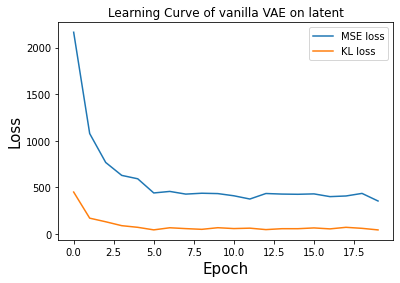

In [34]:
plot_comp_curves2(loss_h)

In [38]:
sample_vae_pt = my_van_vae.sample_VAE(100)

gen_images = my_vq_vae32.Decoder(sample_vae_pt)
save_grid(gen_images.numpy(), "LayeredVAE_resultsVQ32.jpg")

In [49]:
x = [4, 6]
x += [6, 7]

In [50]:
x

[4, 6, 6, 7]